
## Easy Task: Basic VAE for Hybrid Language Music Clustering

This notebook implements the **Easy Task** described in the project document. It uses a small hybrid language music dataset containing English and Bangla songs to train a simple Variational Autoencoder (VAE) for feature extraction. The latent features are then clustered with K-Means and compared against a baseline using PCA + K-Means. Finally, the clusters are visualized using t-SNE, and evaluation metrics (Silhouette Score and Calinski-Harabasz Index) are reported.

### Overview
1. **Load and preprocess data** – remove non-numeric columns and scale features.
2. **Define and train a basic VAE** using TensorFlow/Keras.
3. **Extract latent features** from the trained VAE.
4. **Perform K-Means clustering** on latent features and compute evaluation metrics.
5. **Baseline comparison** using PCA + K-Means.
6. **Visualize clusters** using t-SNE.



In [1]:
# Step 1: Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# After running this cell, authorize access to your Google Drive.


Mounted at /content/drive


In [2]:
# Step 2: Import libraries and load the dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Specify the path to the dataset in your Google Drive.
# Update this path if the file is located elsewhere.
file_path = '/content/drive/My Drive/CSE425/combined_hybrid_features.csv'

# Load the CSV into a pandas DataFrame
df = pd.read_csv(file_path)

# Display basic information about the dataset
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (2000, 30)


,file_name,language,genre,zero_crossing,spectral_centroid,spectral_rolloff,spectral_bandwidth,chroma_frequency,rmse,tempo,...,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19
0,jazz.00021.wav,en,jazz,0.181372,2915.017702,5864.933419,2420.421212,0.432707,0.047977,123.046875,...,-13.805632,13.012531,-7.862577,8.019112,-5.967343,9.531877,-6.002379,2.347543,-3.352306,2.508936
1,pop.00037.wav,en,pop,0.164806,3238.215472,6701.364299,2954.126414,0.451825,0.240985,103.359375,...,3.280029,1.758004,3.346089,2.355284,1.431416,-0.603374,-2.177770,-1.600560,-0.616253,-4.048588
2,pop.00040.wav,en,pop,0.095776,1962.036801,3820.419899,2325.013206,0.292264,0.199328,129.199219,...,-3.760885,4.256140,2.298994,-2.915339,4.516983,3.414072,-0.548955,-0.568484,0.643941,-1.999727
3,metal.00060.wav,en,metal,0.139485,2315.317248,4615.982658,2066.651952,0.540349,0.125761,89.102909,...,-15.680117,9.359065,-15.315594,1.532388,-5.970526,2.051834,-6.810860,4.214549,-3.401198,1.762156
4,hiphop.00011.wav,en,hiphop,0.094151,2095.420824,4581.850948,2241.060906,0.444012,0.203773,135.999178,...,-14.948746,6.881843,-15.326596,4.778063,-11.097589,4.736111,-2.812528,6.798242,-5.803802,-3.767237


In [6]:
# Step 3: Preprocess the data
non_numeric_cols = ['file_name', 'language', 'genre']

# Keep only numeric feature columns
features_df = df.drop(columns=non_numeric_cols, errors="ignore")

# Ensure everything is numeric
features_df = features_df.apply(pd.to_numeric, errors="coerce").fillna(0.0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df).astype(np.float32)

labels = df['language'].astype(str).values

print("Scaled feature matrix shape:", X_scaled.shape)
print("Language counts:\n", pd.Series(labels).value_counts())



Scaled feature matrix shape: (2000, 27)
Language counts:
 en    1000
bn    1000
Name: count, dtype: int64


In [7]:
# Step 4: Build and train a basic Variational Autoencoder (VAE)
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)
np.random.seed(42)

input_dim = X_scaled.shape[1]
latent_dim = 2  # keep 2 for easy visualization

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

# Encoder
encoder_inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(32, activation="relu")(encoder_inputs)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(32, activation="relu")(x)
decoder_outputs = layers.Dense(input_dim, activation="linear")(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

# VAE model with custom train_step (this avoids the KerasTensor loss crash)
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            recon = self.decoder(z, training=True)

            # Reconstruction loss (MSE over features)
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - recon), axis=1))

            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

history = vae.fit(X_scaled, epochs=50, batch_size=32, verbose=1)

# Encode data into latent space
z_mean_out, z_log_var_out, z_encoded = encoder.predict(X_scaled, verbose=0)
print("Latent feature shape:", z_encoded.shape)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - kl_loss: 0.4082 - loss: 27.4120 - recon_loss: 27.0038
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.8196 - loss: 25.5022 - recon_loss: 24.6825
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 1.4927 - loss: 22.6684 - recon_loss: 21.1757
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 1.6525 - loss: 21.8362 - recon_loss: 20.1838
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 2.0609 - loss: 20.6609 - recon_loss: 18.6000
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 2.4773 - loss: 19.2793 - recon_loss: 16.8020
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 2.6183 - loss: 18.2957 - recon_loss: 15.6774
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 2.5948 - loss: 18.0095 - recon_loss: 15.4147
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 2.6479 - loss: 17.7160 - recon_loss: 15.0681
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

In [8]:
# Step 5 + Step 6: K-Means on latent features + PCA baseline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA

n_clusters = len(np.unique(labels))  # 2 languages

# VAE latent + KMeans
kmeans_latent = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
clusters_latent = kmeans_latent.fit_predict(z_encoded)

sil_score_latent = silhouette_score(z_encoded, clusters_latent)
ch_score_latent = calinski_harabasz_score(z_encoded, clusters_latent)

print("VAE Latent + K-Means:")
print("  Silhouette Score:", sil_score_latent)
print("  Calinski-Harabasz Index:", ch_score_latent)

# PCA + KMeans baseline
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
clusters_pca = kmeans_pca.fit_predict(X_pca)

sil_score_pca = silhouette_score(X_pca, clusters_pca)
ch_score_pca = calinski_harabasz_score(X_pca, clusters_pca)

print("\nPCA + K-Means baseline:")
print("  Silhouette Score:", sil_score_pca)
print("  Calinski-Harabasz Index:", ch_score_pca)


VAE Latent + K-Means:
  Silhouette Score: 0.35797128
  Calinski-Harabasz Index: 1058.8864

PCA + K-Means baseline:
  Silhouette Score: 0.37878978
  Calinski-Harabasz Index: 1393.0248


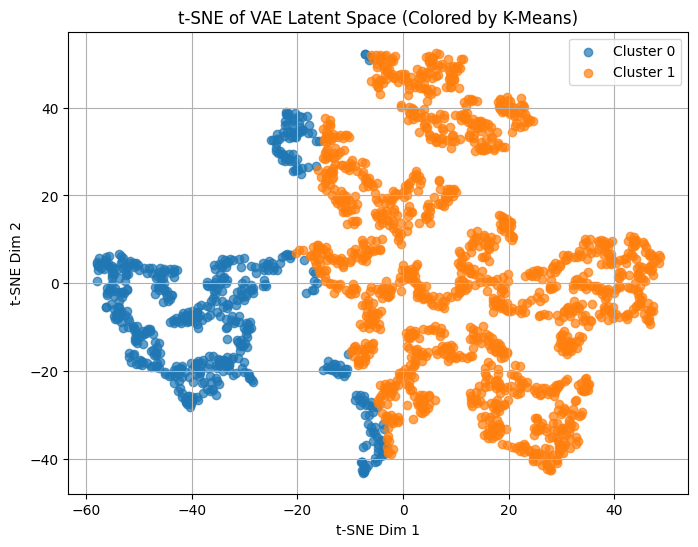

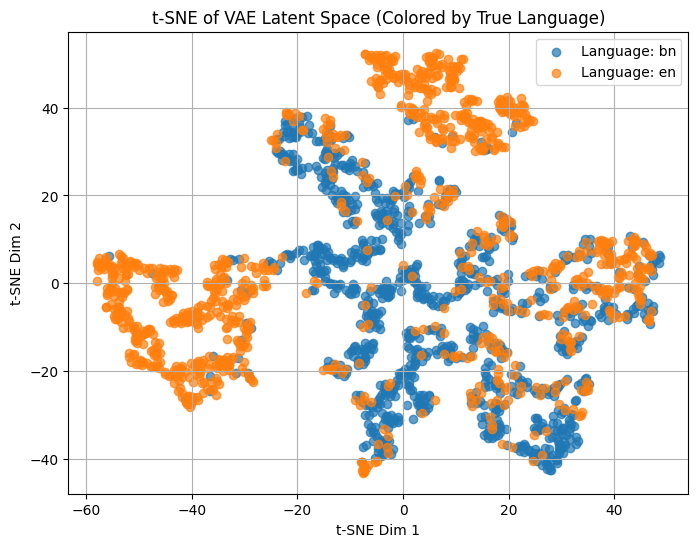

In [9]:
# Step 7: Visualize clusters using t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=30, init="pca")
z_tsne = tsne.fit_transform(z_encoded)

# Plot by KMeans clusters
plt.figure(figsize=(8, 6))
for cluster_id in np.unique(clusters_latent):
    idx = clusters_latent == cluster_id
    plt.scatter(z_tsne[idx, 0], z_tsne[idx, 1], label=f"Cluster {cluster_id}", alpha=0.7)
plt.title("t-SNE of VAE Latent Space (Colored by K-Means)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()
plt.grid(True)
plt.show()

# Plot by true language labels
plt.figure(figsize=(8, 6))
for lang in np.unique(labels):
    idx = labels == lang
    plt.scatter(z_tsne[idx, 0], z_tsne[idx, 1], label=f"Language: {lang}", alpha=0.7)
plt.title("t-SNE of VAE Latent Space (Colored by True Language)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()
plt.grid(True)
plt.show()


===== HIGH-DIM VAE RESULTS =====
latent_dim: 8
Silhouette: 0.3645589
Calinski-Harabasz: 1196.9307


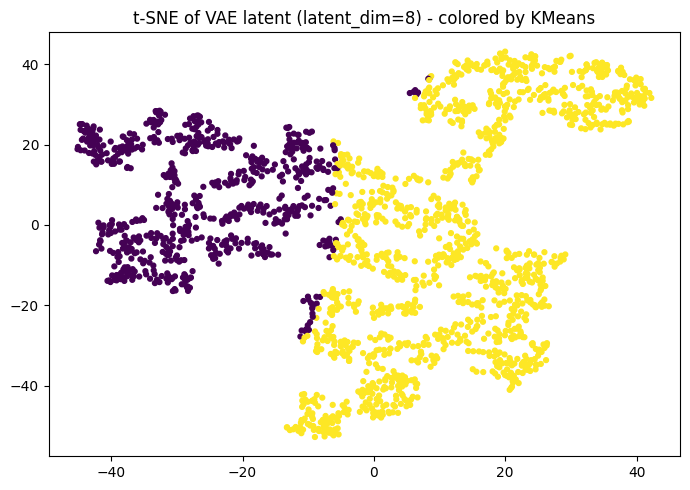

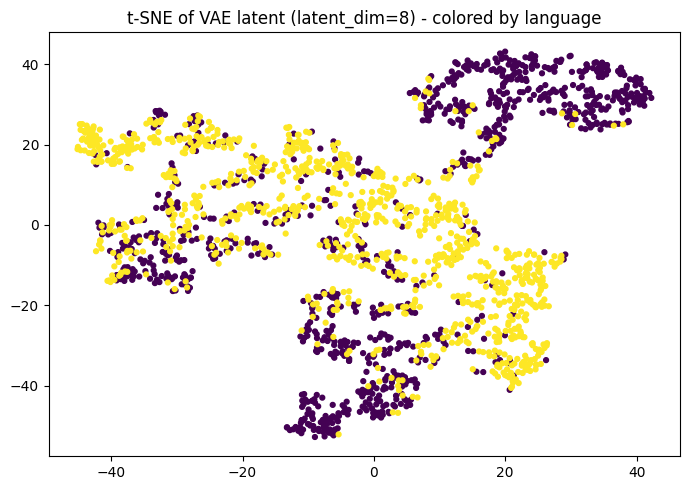

In [11]:
# ==============================
# Higher-dimensional bottleneck run (ONLY)
# Choose latent_dim = 8 or 16
# ==============================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# --- Keep same seed/settings as previous run for fair comparison ---
SEED = 42
EPOCHS = 80          # use same as before
BATCH_SIZE = 64      # same as before
LR = 1e-3            # same as before
BETA = 1.0           # same as before
KMEANS_K = 2         # same as before
TSNE_PERPLEXITY = 35 # same as before

def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=8, h1=32, h2=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.mu = nn.Linear(h2, latent_dim)
        self.logvar = nn.Linear(h2, latent_dim)
        self.fc3 = nn.Linear(latent_dim, h2)
        self.fc4 = nn.Linear(h2, h1)
        self.out = nn.Linear(h1, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        return self.out(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

def vae_loss(x, x_hat, mu, logvar, beta=1.0):
    recon = F.mse_loss(x_hat, x, reduction="mean")
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon.detach().item(), kl.detach().item()

# ---- higher dim ----
LATENT_DIM_HIGH = 8

set_seed(SEED)

X = torch.tensor(X_scaled, dtype=torch.float32)
dl = DataLoader(TensorDataset(X), batch_size=BATCH_SIZE, shuffle=True)

model = VAE(input_dim=X.shape[1], latent_dim=LATENT_DIM_HIGH).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)

history = {"loss": [], "recon": [], "kl": []}

model.train()
for ep in range(1, EPOCHS + 1):
    ep_loss = ep_recon = ep_kl = 0.0
    for (xb,) in dl:
        xb = xb.to(device)
        x_hat, mu, logvar = model(xb)
        loss, r, k = vae_loss(xb, x_hat, mu, logvar, beta=BETA)
        opt.zero_grad()
        loss.backward()
        opt.step()
        ep_loss += loss.item()
        ep_recon += r
        ep_kl += k

    history["loss"].append(ep_loss / len(dl))
    history["recon"].append(ep_recon / len(dl))
    history["kl"].append(ep_kl / len(dl))

# ---- latent extraction (mu) ----
model.eval()
with torch.no_grad():
    mu_all, _ = model.encode(X.to(device))
    Z_high = mu_all.cpu().numpy()

# ---- KMeans ----
km = KMeans(n_clusters=KMEANS_K, random_state=SEED, n_init=10)
clusters_high = km.fit_predict(Z_high)

sil_high = silhouette_score(Z_high, clusters_high)
ch_high = calinski_harabasz_score(Z_high, clusters_high)

print("===== HIGH-DIM VAE RESULTS =====")
print("latent_dim:", LATENT_DIM_HIGH)
print("Silhouette:", sil_high)
print("Calinski-Harabasz:", ch_high)

# ---- t-SNE on latent ----
tsne = TSNE(
    n_components=2,
    perplexity=TSNE_PERPLEXITY,
    random_state=SEED,
    init="pca",
    learning_rate="auto",
)
Z2_high = tsne.fit_transform(Z_high)

plt.figure(figsize=(7,5))
plt.scatter(Z2_high[:,0], Z2_high[:,1], s=12, c=clusters_high)
plt.title(f"t-SNE of VAE latent (latent_dim={LATENT_DIM_HIGH}) - colored by KMeans")
plt.tight_layout()
plt.savefig(f"tsne_highdim_{LATENT_DIM_HIGH}_clusters.png", dpi=160)
plt.show()

#coloured by language
y_true = df['language'].values
plt.figure(figsize=(7,5))
plt.scatter(Z2_high[:,0], Z2_high[:,1], s=12, c=(y_true=='bn').astype(int))
plt.title(f"t-SNE of VAE latent (latent_dim={LATENT_DIM_HIGH}) - colored by language")
plt.tight_layout()
plt.savefig(f"tsne_highdim_{LATENT_DIM_HIGH}_language.png", dpi=160)
plt.show()
